# Collecte de données


In [39]:
import os
import pandas as pd

# === Récupération du type de fichier image associé à chaque pokémon ===
lst_files = os.listdir('images/images')
lst_files = [f.split('.') for f in lst_files]
dico_files = {paire[0]: paire[1] for paire in lst_files}

#importation des données depuis un fichier csv
with open('images/pokemon.csv', 'r') as csv_file:
    # === Pré-traitement des données ===
    lines = csv_file.readlines()
    lines = lines[1:]  #suppression de la première ligne (entête)

    for i, data in enumerate(lines):
        data = data.replace('\n', '')
        lines[i] = data.split(',')
        if len(lines[i]) == 2:  #si le pokémon n'a qu'un seul type
            lines[i].append(None)  #ajout d'une colonne vide pour le second type
        #récupération du type de fichier image associé   
        lines[i].append(dico_files[lines[i][0]])

    # === Création d'un DataFrame ===      
    df = pd.DataFrame(lines, columns=["name", "type1", "type2", "img_type"])

    csv_file.close()

# Export du DataFrame vers un fichier JSON
df.to_json('donnees.json', orient='index')

# Étiquetage et annotation

In [40]:
from PIL import Image
import numpy
import math
import pandas as pd
from sklearn.cluster import KMeans

import Color as color

# /!\ Attention, cette cellule peut prendre plusieurs minutes à s'exécuter

# === chargement des données depuis le fichier JSON ===
df = pd.read_json('donnees.json', orient='index')
#ajout d'une colonne pour les couleurs dominantes
df['colors'] = None

# === Traitement des données ===
for pokemon in df.iterrows():
    img = Image.open(f"images/images/{pokemon[1]['name']}.{pokemon[1]['img_type']}")
    numarray = numpy.array(img, numpy.uint8)
    numarray = numarray.reshape(-1, 9)

    # récupération des couleurs dominantes
    n_clusters = 5
    clusters = KMeans(n_clusters=n_clusters, n_init=20)
    clusters.fit(numarray)

    couleurs = []
    for i in range(len(clusters.cluster_centers_)):
        couleurs.append([numpy.sum(clusters.labels_ == i), "#%02x%02x%02x" % (
            math.ceil(clusters.cluster_centers_[i][0]),
            math.ceil(clusters.cluster_centers_[i][1]),
            math.ceil(clusters.cluster_centers_[i][2]),
        )])

    #filtrage des couleurs de fond (blanc pour jpg, noir pour png)
    couleurs = sorted(couleurs, key=lambda x: x[0], reverse=True)
    if (pokemon[1]['img_type'] == 'jpg') and (color.is_near(couleurs[0][1], '#ffffff', 10, mode='HEX')):
        couleurs.pop(0)
    elif (pokemon[1]['img_type'] == 'png') and (color.is_near(couleurs[0][1], '#000000', 10, mode='HEX')):
        couleurs.pop(0)
    else:
        couleurs.pop(-1)

    #Normalisation des valeurs de quantité de couleurs
    sum = 0
    for paire in couleurs:
        sum += paire[0]
    for paire in couleurs:
        paire[0] = int((paire[0] / sum) * 100)

    # === Ajout des couleurs dominantes au DataFrame ===
    df.at[pokemon[0], 'colors'] = couleurs

# Export du DataFrame vers le fichier JSON
df.to_json('donnees.json', orient='index')

# Analyses de données


In [41]:
import ipywidgets as widgets
from ipywidgets import GridspecLayout, Image, interact
import random
from IPython.display import display
import pandas as pd

# === chargement des données depuis le fichier JSON ===
df = pd.read_json('donnees.json', orient='index')
#ajout d'une colonne pour la variable de préférence
df['preferences'] = None


# === Function executé lors du click sur le bouton ===
def get_selected_images(btn):
    # Récupération des identifiants des images sélectionnées
    selected_ids = [list_id[i] for i, checkbox in enumerate(checkboxes) if checkbox.value]
    # traitement des préférences
    with output:
        output.clear_output()
        for id in list_id:
            if id in selected_ids:
                preferences(id, 2)  # Appel de la fonction preferences avec la valeur 1
            else:
                preferences(id, -1)  # Appel de la fonction preferences avec la valeur -0.5

        # enregistrement du DataFrame dans le fichier JSON
        print("Données enregistrés dans le fichier JSON")
        df.to_json('donnees.json', orient='index')


# === création du widget d'images et de checkboxes ===       
def preferences(image_id, valeur):
    # Mise à jour de la variable de préférence
    df.at[image_id, 'preferences'] = valeur


list_id = []
# liste d'identifiants d'images aléatoires (pas de doublons)
while len(list_id) < 50:
    id = random.randint(0, len(df) - 1)
    if id not in list_id:
        list_id.append(id)

checkboxes = [widgets.Checkbox(value=False, description='Aime') for _ in range(len(list_id))]

# Create the GridspecLayout widget
layout = GridspecLayout(n_columns=2, n_rows=len(list_id), width='400px')
for i, (id, checkbox) in enumerate(zip(list_id, checkboxes)):
    image = open(f"images/images/{df.iloc[id]['name']}.{df.iloc[id]['img_type']}", "rb").read()
    image_widget = widgets.Image(
        value=image,
        format='png',
        width=100,
        height=100,
    )
    layout[i, 0] = image_widget
    layout[i, 1] = checkbox

# Button to get selected images
button_select = widgets.Button(description="Select")

# Output widget to display selected images
output = widgets.Output()

# Link button click event to function
button_select.on_click(get_selected_images)

# Display the layout and button
display(layout, button_select, output)


GridspecLayout(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00x\x00\x00\x00x\x08\x03\x…

Button(description='Select', style=ButtonStyle())

Output()

# Visualisation des données

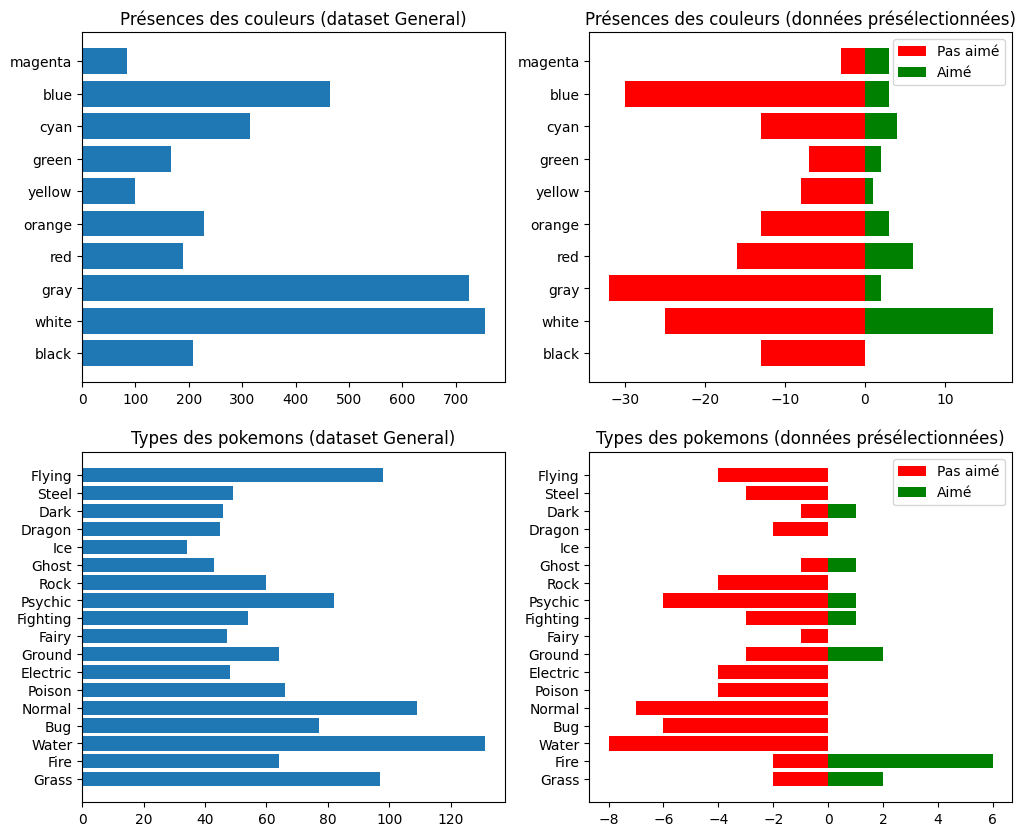

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

import Color as color

# === chargement des données depuis le fichier JSON ===
df = pd.read_json('donnees.json', orient='index')

# === récupération des données à visualiser ===
# liste de couleurs de référence
lst_color_names = color.name_list()

# liste de types de pokémon
lst_types = df['type1'].unique()

# dico de statistiques pour les couleurs
stats_couleurs_generals = {}
stats_couleurs_preferences_plus = {}
stats_couleurs_preferences_moins = {}
# initialisation
for val in lst_color_names:
    stats_couleurs_generals[val] = 0
    stats_couleurs_preferences_plus[val] = 0
    stats_couleurs_preferences_moins[val] = 0

# dico de statistiques pour les types
stats_types_generals = {}
stats_types_preferences_plus = {}
stats_types_preferences_moins = {}
# initialisation
for val in lst_types:
    stats_types_generals[val] = 0
    stats_types_preferences_plus[val] = 0
    stats_types_preferences_moins[val] = 0

# Boucle de construction des statistiques
for pokemon in df.iterrows():
    # == statistiques des types ==
    # pour les statistiques générales
    stats_types_generals[pokemon[1]['type1']] += 1
    # pour les statistiques des images choisies pour les préférences
    if pokemon[1]['preferences'] == 2:
        stats_types_preferences_plus[pokemon[1]['type1']] += 1
    # pour les statistiques des images non choisies pour les préférences
    elif pokemon[1]['preferences'] == -1:
        stats_types_preferences_moins[pokemon[1]['type1']] += 1

    if pokemon[1]['type2'] is not None:
        # pour les statistiques générales
        stats_types_generals[pokemon[1]['type2']] += 1
        # pour les statistiques des images choisies pour les préférences
        if pokemon[1]['preferences'] == 2:
            stats_types_preferences_plus[pokemon[1]['type2']] += 1
        # pour les statistiques des images non choisies pour les préférences
        elif pokemon[1]['preferences'] == -1:
            stats_types_preferences_moins[pokemon[1]['type2']] += 1

    # == statistiques des couleurs ==
    for pair in pokemon[1]['colors']:
        hsv = color.hex_to_hsv(pair[1])
        couleur = color.get_color_name(hsv)
        # pour les statistiques générales
        stats_couleurs_generals[couleur] += 1
        # pour les statistiques des images choisies pour les préférences
        if pokemon[1]['preferences'] == 2:
            stats_couleurs_preferences_plus[couleur] += 1
        # pour les statistiques des images non choisies pour les préférences
        elif pokemon[1]['preferences'] == -1:
            stats_couleurs_preferences_moins[couleur] += 1

# === Affichage des statistiques ===
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Graphique 1 : stats_couleurs_generals
axs[0, 0].barh(list(stats_couleurs_generals.keys()), list(stats_couleurs_generals.values()))
axs[0, 0].set_title('Présences des couleurs (dataset General)')

# Graphique 2 : stats_couleurs_preferences_plus et stats_couleurs_preferences_moins
keys = list(stats_couleurs_preferences_plus.keys())
values_plus = list(stats_couleurs_preferences_plus.values())
values_moins = [-val for val in stats_couleurs_preferences_moins.values()]  # Valeurs négatives
axs[0, 1].barh(keys, values_moins, color='red', label='Pas aimé')
axs[0, 1].barh(keys, values_plus, color='green',
               label='Aimé')  # Utilisation de 'left' pour spécifier le point de départ
axs[0, 1].set_title('Présences des couleurs (données présélectionnées)')
axs[0, 1].legend()

# Graphique 3 : stats_types_generals
axs[1, 0].barh(list(stats_types_generals.keys()), list(stats_types_generals.values()))
axs[1, 0].set_title('Types des pokemons (dataset General)')

# Graphique 4 : stats_types_preferences_plus et stats_types_preferences_moins
keys = list(stats_types_preferences_plus.keys())
values_plus = list(stats_types_preferences_plus.values())
values_moins = [-val for val in stats_types_preferences_moins.values()]  # Valeurs négatives
axs[1, 1].barh(keys, values_moins, color='red', label='Pas aimé')
axs[1, 1].barh(keys, values_plus, color='green',
               label='Aimé')  # Utilisation de 'left' pour spécifier le point de départ
axs[1, 1].set_title('Types des pokemons (données présélectionnées)')
axs[1, 1].legend()

# Système de recommandation


In [8]:
import pandas as pd

import Color as color

# /!\ Attention, cette cellule peut prendre plusieurs minutes à s'exécuter

# === chargement des données depuis le fichier JSON ===
df = pd.read_json('donnees.json', orient='index')
#ajout d'une colonne pour la variable de possibilité d'aimer
df['likeable'] = float(0)


# Calcule et renvoie la similarite des types de deux pokemons
def type_similarity(pok1, pok2):
    # Creation de deux sets regroupants les types de deux pokemons
    set1 = {pok1['type1'], pok1['type2']}
    set2 = {pok2['type1'], pok2['type2']}

    # Calcul de la similarite
    similarity = 0.15
    if set1.isdisjoint(set2):
        similarity -= 0.20
    return similarity


# Calcule la similarite entre les couleurs dominantes de deux pokemons
def color_similarity(pok1, pok2):
    # Creation de deux sets regroupants les couleurs principales de deux pokemons
    set1 = {pok1['colors'][0][1], pok1['colors'][1][1], pok1['colors'][2][1], pok1['colors'][3][1]}
    set2 = {pok2['colors'][0][1], pok2['colors'][1][1], pok2['colors'][2][1], pok2['colors'][3][1]}

    # Verification de la similarite des couleurs grace a is_near()
    list_bool = []
    for color1 in set1:
        for color2 in set2:
            sim_bool = color.is_near(color1, color2, 30, "HEX")
            list_bool.append(sim_bool)

    # Calcule et renvoie l'indice de similarite
    similarity = 0.05 * list_bool.count(True) - 0.05
    return similarity

# Variable de ration like dislike
ratio = 0
# Creation d'une liste contenant tous les pokemons notes auparavant
list_pok_notes = []
for pokemon in df.iterrows():
    if isinstance(pokemon[1]['preferences'], float):
        list_pok_notes.append(pokemon)
        if pokemon[1]['preferences'] == 2:
            ratio += 1
ratio /= len(list_pok_notes)

# Traitement des pokemons notes pour ajuster les notes du reste des pokemons
# en fonction des criteres d'appreciation detectes
for pok1 in list_pok_notes:
    multiple = (2 * ratio) if pok1[1]['preferences'] == 2 else (-1 * (1-ratio))
    print(multiple)
        
    for pok2 in df.iterrows():
        if pok1[0] != pok2[0]:
            similarity_type = type_similarity(pok1[1], pok2[1])
            similarity_color = color_similarity(pok1[1], pok2[1])

            #pok2[1]['likeable'] += similarity_type + similarity_color
            df.at[pok2[0], 'likeable'] += (similarity_type + similarity_color) * multiple

# Ecriture des donnees d'appreciation théorique dans le fichier JSON
df.to_json('donnees.json', orient='index')

-0.9876390605686032


KeyboardInterrupt: 

In [7]:
import ipywidgets as widgets
from ipywidgets import GridspecLayout, Image, interact
from IPython.display import display

# === Affichage des 10 pokémons les plus recommandés (dans l'ordre décroissant) ===
# Tri des données par ordre décroissant de la variable 'likeable'
df = df.sort_values(by='likeable', ascending=False)

# récupération des 10 premiers (non utilisés dans les préférences)
df = df[df['preferences'].isnull()].head(10)
print(df)

# Création du widget d'images
layout = GridspecLayout(n_columns=2, n_rows=10, width='400px')
for i, pokemon in enumerate(df.iterrows()):
    image = open(f"images/images/{pokemon[1]['name']}.{pokemon[1]['img_type']}", "rb").read()
    image_widget = widgets.Image(
        value=image,
        format='png',
        width=100,
        height=100,
    )
    layout[i, 0] = image_widget
    # Ajout du nom du pokémon et de son numéro
    layout[i, 1] = widgets.Label(value=f"{pokemon[1]['name']} | {pokemon[0]}")

# Display the layout
display(layout)


               name   type1     type2 img_type  \
197         murkrow    Dark    Flying      png   
643          zekrom  Dragon  Electric      png   
716         yveltal    Dark    Flying      png   
499          emboar    Fire  Fighting      png   
412  wormadam-plant     Bug     Grass      png   
524         boldore    Rock      None      png   
318        sharpedo   Water      Dark      png   
110         rhyhorn  Ground      Rock      png   
759          bewear  Normal  Fighting      png   
717      zygarde-50  Dragon    Ground      png   

                                                colors  preferences  \
197  [[30, #4d68e1], [26, #ef4754], [21, #23354b], ...          NaN   
643  [[27, #394b52], [25, #5ff04d], [23, #5051f0], ...          NaN   
716  [[29, #5be870], [26, #3135d6], [23, #5a3a42], ...          NaN   
499  [[35, #f09c6d], [24, #3cf38c], [23, #5f32fb], ...          NaN   
412  [[34, #8369e0], [23, #386231], [21, #43f33c], ...          NaN   
524  [[26, #3e374e], [2

GridspecLayout(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00x\x00\x00\x00x\x08\x06\x…

# Tests

pass